# Setting up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from imblearn.over_sampling import SMOTE, SMOTENC
from collections import Counter

df = pd.read_csv('final.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36330 entries, 0 to 36329
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   icustay_id                   36330 non-null  int64  
 1   day_28_flag                  36330 non-null  int64  
 2   icu_exp_flag                 36330 non-null  int64  
 3   day_28_after_discharge_flag  36330 non-null  int64  
 4   ethnicity                    36330 non-null  object 
 5   gender                       36330 non-null  object 
 6   age                          36330 non-null  float64
 7   length_of_stay               36330 non-null  float64
 8   service_type                 36330 non-null  object 
 9   weight                       36330 non-null  float64
 10  height                       36330 non-null  float64
 11  sofa                         36330 non-null  int64  
 12  DiasBP                       36330 non-null  float64
 13  HeartRate       

In [2]:
id_col = 'icustay_id'

target_col = 'day_28_after_discharge_flag'

#20 numerical columns
numerical_cols = ['age', 'length_of_stay', 'sofa', 'DiasBP', 'HeartRate', 'MAP', 'SpO2',
                 'SysBP', 'Temperature', 'BUN', 'CHLORIDE', 'CREATININE', 'HEMOGLOBIN', 'PLATELET', 'POTASSIUM',
                 'SODIUM', 'TOTALCO2', 'WBC', 'bmi', 'eGFR']

#2 categorical columns
categorical_cols = ['gender', 'service_type']

In [3]:
# combine the functions above
# check categorical columns
def explore_categorical_columns(df,categorical_cols):
    nunique_values = []
    na_values = []
    for col in categorical_cols:
        nunique_values.append(df[col].nunique())
        na_values.append(len(df.loc[df[col].isna()]))
    df_stats_categorical = pd.DataFrame(list(zip(categorical_cols,nunique_values,na_values)),columns=['Column_Name','#Unique_Values','#Null_Value'])
    df_null = df_stats_categorical[df_stats_categorical['#Null_Value']>0]
    df_unique_value = df_stats_categorical[df_stats_categorical['#Unique_Values'] == 1]
    if len(df_null) > 0:
        print('Columns with Null value: %s'%(str(df_null['Column_Name'])))
    else:
        print('There is no Null values in the categorical columns')
    if len(df_unique_value) > 0:
        print('Columns with only 1 unique value: %s'%(str(list(df_unique_value['Column_Name']))))
    else:
        print('All categorical columns have more than 1 value.')
        
#check numerical columns
def explore_numerical_columns(df,numerical_cols):
    na_values = []
    for col in numerical_cols:
        na_values.append(len(df.loc[df[col].isna()]))
    df_stats_numerical = pd.DataFrame(list(zip(numerical_cols,na_values)),columns=['Column_Name','#Null_Value'])
    df_null = df_stats_numerical[df_stats_numerical['#Null_Value']>0]
    df_stats = df[numerical_cols].describe().T
    df_unique_value = df_stats[df_stats['std']==0]
    
    if len(df_null) > 0:
        print('Columns with Null value: %s'%(str(df_null['Column_Name'])))
    else:
        print('There is no Null values in the numerical columns')
    
    if len(df_unique_value) > 0:
        print('Columns with only 1 unique value: %s'%(str(list(df_unique_value.index))))
    else:
        print('All numerical columns have more than 1 value. \n')

#check categorical columns
print('Categorical_Columns'.center(50,"*"))
explore_categorical_columns(df,categorical_cols)
print('Numerical_Columns'.center(50,"*"))
#check numerical columns
explore_numerical_columns(df,numerical_cols)

***************Categorical_Columns****************
There is no Null values in the categorical columns
All categorical columns have more than 1 value.
****************Numerical_Columns*****************
There is no Null values in the numerical columns
All numerical columns have more than 1 value. 



In [4]:
# Check target variable
df[target_col].unique()

array([0, 1])

In [5]:
# Check class imbalance
df[target_col].value_counts()

0    33746
1     2584
Name: day_28_after_discharge_flag, dtype: int64

In [6]:
df_features = pd.concat([df[numerical_cols], df[categorical_cols]],axis=1)
df_labels = df[target_col]

# Decision Tree Classifier with SMOTE-NC

In [7]:
# Baseline Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_curve, auc
from statistics import mean, stdev

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24, 25, 26])
testscore = []
recall = []
auc = []

for i in range(30):
    # Split the data into train and test (75% - 25%)
    train_x, test_x, y_train, y_test = train_test_split(df_features,df_labels,test_size=0.25,random_state=i)

    # Preprocessing
    numerical_train_x = train_x[numerical_cols].reset_index(drop=True)
    categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]]).reset_index(drop=True)
    X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
    numerical_test_x = test_x[numerical_cols].reset_index(drop=True)
    categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]]).reset_index(drop=True)
    X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

    # Modelling
    X, y = oversample.fit_resample(X_train, y_train)

    dtc = DecisionTreeClassifier()
    dtc.fit(X, y)
    
    # test_accuracy_base
    testscore.append(dtc.score(X_test,y_test))
    y_true_base, y_pred_base = y_test , dtc.predict(X_test)
    
    # recall_base 
    recall.append(recall_score(y_true_base, y_pred_base))
    
    probs_base = dtc.predict_proba(X_test)
    preds_base = probs_base[:,1]
    fpr_base, tpr_base, threshold = metrics.roc_curve(y_true_base, preds_base)
    
    # roc_auc_base 
    auc.append(metrics.auc(fpr_base, tpr_base))

print("Test set score: {0:.3f} +/- {1:.3f}".format(mean(testscore), stdev(testscore)))
print("Recall: {0:.3f} +/- {1:.3f}".format(mean(recall), stdev(recall)))
print("AUC: {0:.3f} +/- {1:.3f}".format(mean(auc), stdev(auc)))

Test set score: 0.860 +/- 0.003
Recall: 0.263 +/- 0.018
AUC: 0.584 +/- 0.009


# Hyperparameter Tuning - SMOTE-NC

In [8]:
# DTC - Randomised Tuning

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_curve, auc, make_scorer, accuracy_score
from statistics import mean, stdev
import seaborn as sns

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])

max_features = ['log2', 'sqrt']
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]

# Split the data into train and test (75% - 25%)
train_x, test_x, y_train, y_test = train_test_split(df_features,df_labels,test_size=0.25)

# Preprocessing
numerical_train_x = train_x[numerical_cols].reset_index(drop=True)
categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
numerical_test_x = test_x[numerical_cols].reset_index(drop=True)
categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

# Modelling
X, y = oversample.fit_resample(X_train, y_train)

dtc = DecisionTreeClassifier()
param_dist = {'max_features': max_features,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

scorers = {
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

dtc_rdm = RandomizedSearchCV(dtc, param_dist, scoring = scorers, refit = 'recall_score', n_iter = 100, cv = 5, verbose = 1, n_jobs=-1)

dtc_rdm.fit(X, y)

dtc_df = pd.DataFrame(dtc_rdm.cv_results_).sort_values(by=['rank_test_recall_score', 'rank_test_accuracy_score']).reset_index(drop=True)
dtc_df = dtc_df[['param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 
                 'mean_test_recall_score', 'std_test_recall_score', 'mean_test_accuracy_score', 'std_test_accuracy_score']]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.8s finished


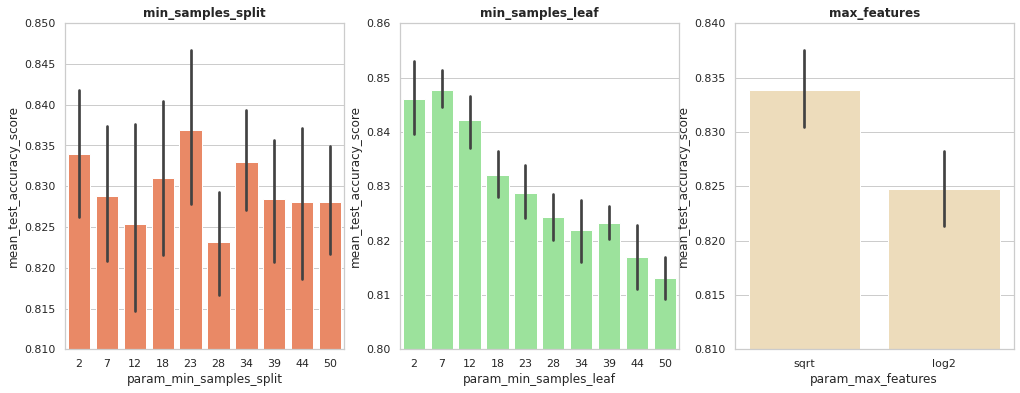

In [10]:
fig, axs = plt.subplots(ncols=3, nrows=1)
sns.set(style="whitegrid", color_codes=True)
fig.set_size_inches(17,6)
sns.barplot(x='param_min_samples_split', y='mean_test_accuracy_score', data=dtc_df, ax=axs[0], color='coral')
axs[0].set_ylim([0.81,0.85]),axs[0].set_title(label = 'min_samples_split', weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_accuracy_score', data=dtc_df, ax=axs[1], color='lightgreen')
axs[1].set_ylim([0.8,0.86]),axs[1].set_title(label = 'min_samples_leaf', weight='bold')
sns.barplot(x='param_max_features', y='mean_test_accuracy_score', data=dtc_df, ax=axs[2], color='wheat')
axs[2].set_ylim([0.81,0.84]),axs[2].set_title(label = 'max_features', weight='bold')
plt.show()

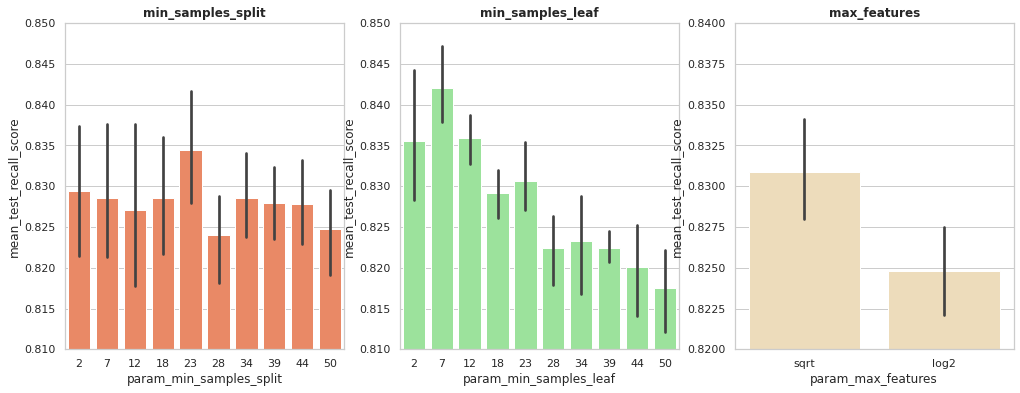

In [12]:
fig, axs = plt.subplots(ncols=3, nrows=1)
sns.set(style="whitegrid", color_codes=True)
fig.set_size_inches(17,6)
sns.barplot(x='param_min_samples_split', y='mean_test_recall_score', data=dtc_df, ax=axs[0], color='coral')
axs[0].set_ylim([0.81,0.85]),axs[0].set_title(label = 'min_samples_split', weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_recall_score', data=dtc_df, ax=axs[1], color='lightgreen')
axs[1].set_ylim([0.81,0.85]),axs[1].set_title(label = 'min_samples_leaf', weight='bold')
sns.barplot(x='param_max_features', y='mean_test_recall_score', data=dtc_df, ax=axs[2], color='wheat')
axs[2].set_ylim([0.82,0.84]),axs[2].set_title(label = 'max_features', weight='bold')
plt.show()

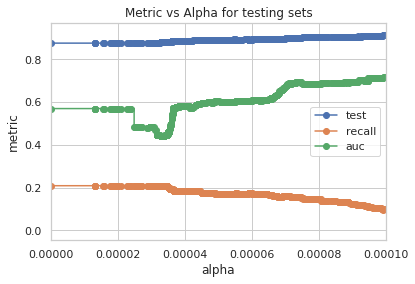

In [13]:
# Hyperparameter Tuning - Minimal Cost Complexity Pruning

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_curve, auc
from statistics import mean, stdev

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])

# Split the data into train and test (75% - 25%)
train_x, test_x, y_train, y_test = train_test_split(df_features,df_labels,test_size=0.25)

# Preprocessing
numerical_train_x = train_x[numerical_cols].reset_index(drop=True)
categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
numerical_test_x = test_x[numerical_cols].reset_index(drop=True)
categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

# Modelling
X, y = oversample.fit_resample(X_train, y_train)

dtc = DecisionTreeClassifier()
dtc.fit(X, y)
    
path = dtc.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
clfs = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha = alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
        
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

testscore = []
recall = []
auc = []
for clf in clfs:
    testscore.append(clf.score(X_test, y_test))
    y_true_base, y_pred_base = y_test , clf.predict(X_test)
    recall.append(recall_score(y_true_base, y_pred_base))
    probs_base = clf.predict_proba(X_test)
    preds_base = probs_base[:,1]
    fpr_base, tpr_base, threshold = metrics.roc_curve(y_true_base, preds_base)
    auc.append(metrics.auc(fpr_base, tpr_base))

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("metric")
ax.set_title("Metric vs Alpha for testing sets")
ax.plot(ccp_alphas, testscore, marker='o', label="test",
        drawstyle="steps-post")
ax.plot(ccp_alphas, recall, marker='o', label="recall",
        drawstyle="steps-post")
ax.plot(ccp_alphas, auc, marker='o', label="auc",
        drawstyle="steps-post")
ax.legend()
plt.xlim(0,0.0001)
plt.show()

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_curve, auc
from statistics import mean, stdev
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
import time

start_time = time.time()

max_depth = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])

test_total = []
recall_total = []
auc_total = []

for i in range(30):
    test = []
    recall = []
    auc = []
    
    # Split the data into train and test (75% - 25%)
    train_x, test_x, y_train, y_test = train_test_split(df_features,df_labels,test_size=0.25,random_state=i)

    # Preprocessing
    numerical_train_x = train_x[numerical_cols].reset_index(drop=True)
    categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
    numerical_test_x = test_x[numerical_cols].reset_index(drop=True)
    categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

    # Modelling
    X, y = oversample.fit_resample(X_train, y_train)

    for d in max_depth:
        dtc = DecisionTreeClassifier(max_depth = d)
        dtc.fit(X, y)
    
        # test_accuracy
        test.append(dtc.score(X_test,y_test))
        y_true_base, y_pred_base = y_test , dtc.predict(X_test)
    
        # recall
        recall.append(recall_score(y_true_base, y_pred_base))
    
        probs_base = dtc.predict_proba(X_test)
        preds_base = probs_base[:,1]
        fpr_base, tpr_base, threshold = metrics.roc_curve(y_true_base, preds_base)
    
        # roc_auc
        auc.append(metrics.auc(fpr_base, tpr_base))
    
    test_total.append(test)
    recall_total.append(recall)
    auc_total.append(auc)

test_total = list(zip(*test_total))
recall_total = list(zip(*recall_total))
auc_total = list(zip(*auc_total))

test_mean = [mean(x) for x in test_total]
recall_mean = [mean(x) for x in recall_total]
auc_mean = [mean(x) for x in auc_total]

print('Time taken for training the model: '+ str(time.time() - start_time))

Time taken for training the model: 298.8773989677429


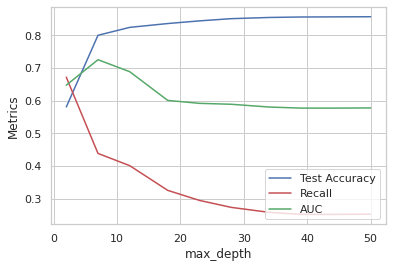

In [15]:
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt

plt.plot(max_depth, test_mean, color='b', label='Test Accuracy')
plt.plot(max_depth, recall_mean, color='r', label='Recall')
plt.plot(max_depth, auc_mean, color='g', label='AUC')
plt.legend(loc = 'lower right')
plt.ylabel('Metrics')
plt.xlabel('max_depth')
plt.show()

In [8]:
# Tuned Model

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_curve, auc
from statistics import mean, stdev
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

feats = {}
ds = []
d = {}
testscore = []
recall = []
auc = []

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 5, num = 4)]
min_samples_split = [22,23,24]
min_samples_leaf = [6,7,8]
ccp_alpha = [float(x) for x in np.linspace(start = 0.00006, stop = 0.00007, num = 25)]

param_dist = {'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'ccp_alpha': ccp_alpha}

for i in range(30):
    # Split the data into train and test (75% - 25%)
    train_x, test_x, y_train, y_test = train_test_split(df_features,df_labels,test_size=0.25,random_state=i)

    # Preprocessing
    numerical_train_x = train_x[numerical_cols].reset_index(drop=True)
    categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
    numerical_test_x = test_x[numerical_cols].reset_index(drop=True)
    categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

    # Modelling
    X, y = oversample.fit_resample(X_train, y_train)
    dtc = DecisionTreeClassifier()

    gs_dtc = GridSearchCV(dtc, param_dist, cv = 5, verbose = 1, n_jobs=-1)
    gs_dtc.fit(X, y)
    dtc_gs = gs_dtc.best_estimator_.fit(X, y)
    
    # coefficients
    ds.append(dict(zip(X_train.columns.tolist(), gs_dtc.best_estimator_.feature_importances_)))
    
    # test_accuracy_base
    testscore.append(dtc_gs.score(X_test,y_test))
    y_true_base, y_pred_base = y_test , dtc_gs.predict(X_test)
    
    # recall_base 
    recall.append(recall_score(y_true_base, y_pred_base))
    
    probs_base = dtc_gs.predict_proba(X_test)
    preds_base = probs_base[:,1]
    fpr_base, tpr_base, threshold = metrics.roc_curve(y_true_base, preds_base)
    
    # roc_auc_base 
    auc.append(metrics.auc(fpr_base, tpr_base))

d1 = ds[0]
for k in d1.keys():
    d[k] = tuple(d[k] for d in ds)

for feature, importance in d.items():
    feats[feature] = mean(importance)
    
print("Test set score: {0:.3f} +/- {1:.3f}".format(mean(testscore), stdev(testscore)))
print("Recall: {0:.3f} +/- {1:.3f}".format(mean(recall), stdev(recall)))
print("AUC: {0:.3f} +/- {1:.3f}".format(mean(auc), stdev(auc)))

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 740 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 2340 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 3440 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   27.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   27.8s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.8s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.8s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.8s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   27.0s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.9s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.8s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.9s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 2912 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   25.8s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.8s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 2912 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   25.8s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.8s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.9s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.9s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.9s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.7s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.9s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.8s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.9s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.8s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.9s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.8s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.9s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.8s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.9s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.7s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.9s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.8s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.9s finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4469 out of 4500 | elapsed:   26.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   26.9s finished


Test set score: 0.675 +/- 0.065
Recall: 0.608 +/- 0.076
AUC: 0.696 +/- 0.020


In [9]:
print(feats)

{'age': 0.05245726296611537, 'length_of_stay': 0.22477301272505643, 'sofa': 0.01025904953866143, 'DiasBP': 0.004673359058931444, 'HeartRate': 0.008377062152809272, 'MAP': 0.008341749856760504, 'SpO2': 0.03157039976743116, 'SysBP': 0.016514810625057087, 'Temperature': 0.007067751444388447, 'BUN': 0.17461423763684558, 'CHLORIDE': 0.0017572399148005342, 'CREATININE': 0.04713552606628381, 'HEMOGLOBIN': 0.005267638202699092, 'PLATELET': 0.013043413998949956, 'POTASSIUM': 0.000992047939914804, 'SODIUM': 0.002287492205955036, 'TOTALCO2': 0.0028726520395691156, 'WBC': 0.00415420707782112, 'bmi': 0.01089418588311381, 'eGFR': 0.04714751734154054, 'gender_M': 0.0007606977864156225, 'service_type_CSRU': 0.214002677807167, 'service_type_MICU': 0.040070218470255, 'service_type_SICU': 0.037145691388533145, 'service_type_TSICU': 0.03382009810492467}


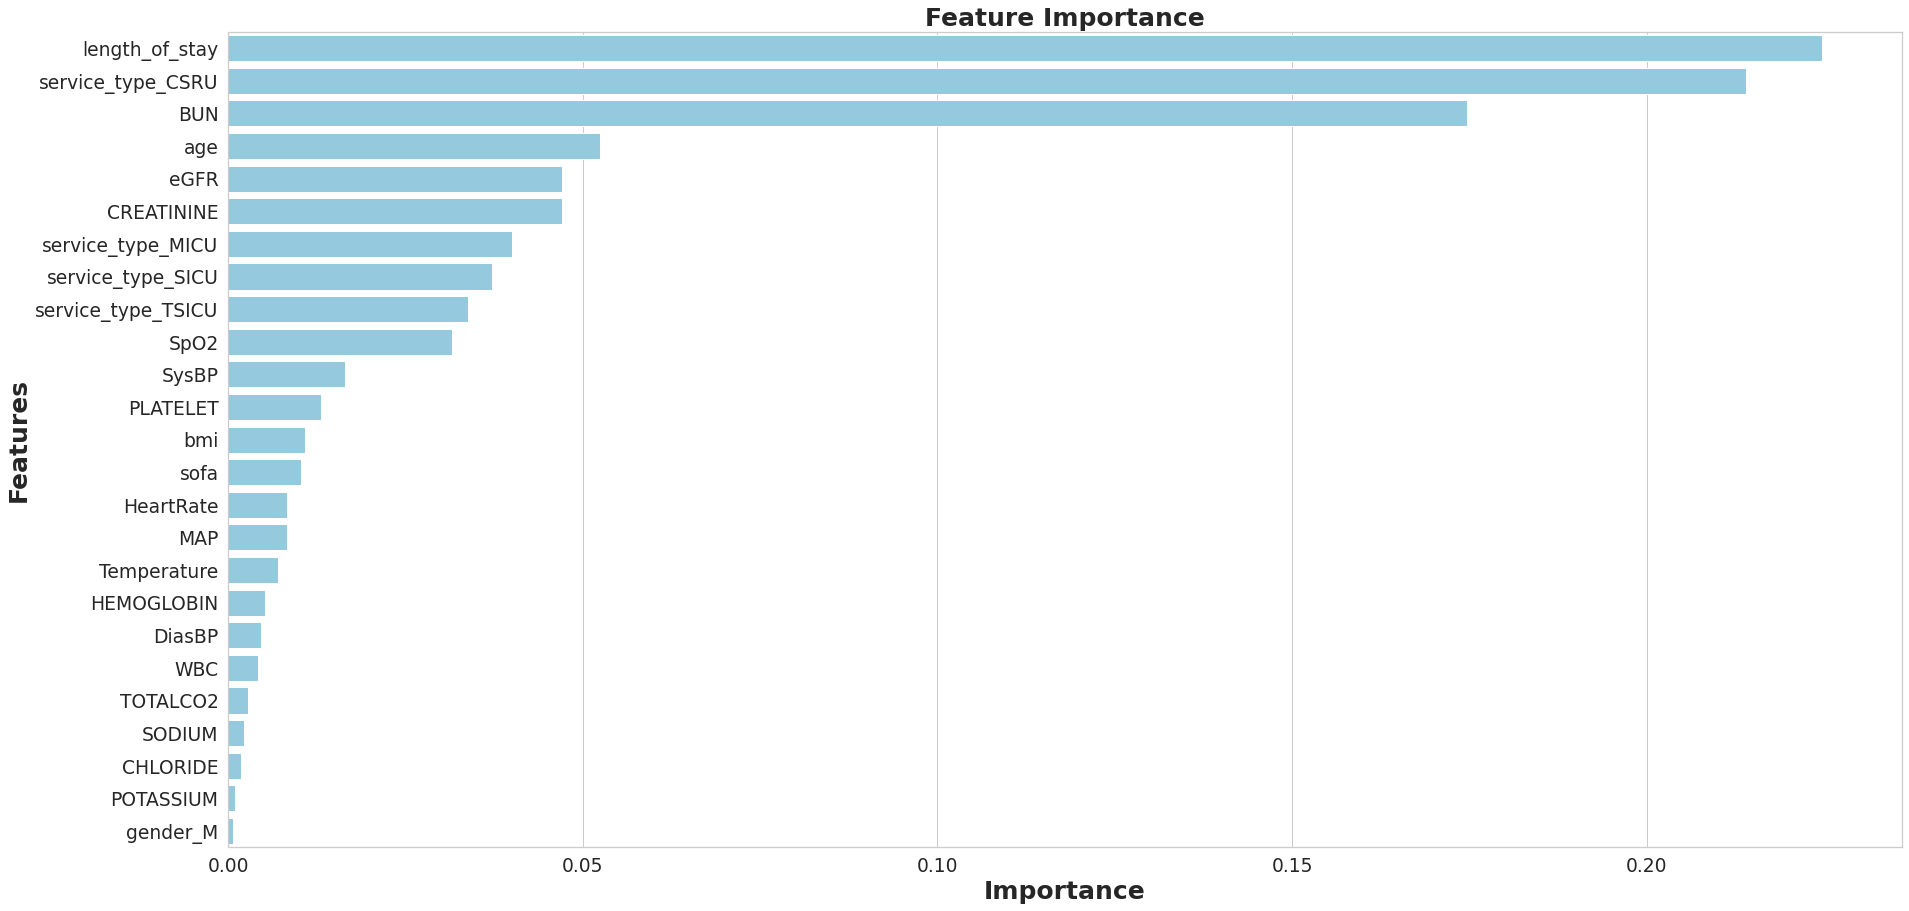

None

,Features,Gini-Importance
0,length_of_stay,0.224773
1,service_type_CSRU,0.214003
2,BUN,0.174614
3,age,0.052457
4,eGFR,0.047148
5,CREATININE,0.047136
6,service_type_MICU,0.040070
7,service_type_SICU,0.037146
8,service_type_TSICU,0.033820
9,SpO2,0.031570


In [10]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)